In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
############################################################
'''
Part 2: RK4 Validation with rocket dynamic + PID control
'''
############################################################

## parameter setup
# Integration parameter 
h=1/1000    # step size    (sec)
t0=0        # initial time (sec)
tf=10       # final time (sec)


time=np.linspace(t0,tf,int((tf-t0)/h))

## Pressure / Valve
p_s=11e5
p3_max_range=11*1e5
p3_actual_t0=1e5
p3_u_t0=1e5
md4n_t0=0

Open_t=825e-3       # opening time [s]
Close_t=1700e-3     # closing time[s]

state_t0=np.array([p3_actual_t0,p3_u_t0,md4n_t0])
state_t=np.zeros((len(state_t0),len(time)))

## motion initial state
x_t0=0.0
v_t0=0.0
a_t0=0.0

x_target=3.0         # height target [m]

motion_t0=np.array([x_t0,v_t0])
motion_t=np.zeros((len(motion_t0),len(time)))

## mass
m_hop=3.5    # mass of hopper [kg]
m_hose=1     # mass of hose   [kg]
k_hose=6     # variable hopper mass [N/m]
F_RR=10      # rolling resistence [N]

## constant
R=8314             # universal gas constant [J/kmol*K]
M=28.013           # nitrogen gas  [kg/kmol]
gamma=1.4          # ratio of specific heats (diatomic gas)
g=9.81             # [m/s^2]

## Nozzle
Th_d=9e-3                       # throat diameter [m]
Th_exit_d=11e-3                 # exit diameter [m]
A_throat=np.pi*(Th_d/2)**2      #[m^2]
A_e=np.pi*(Th_exit_d/2)**2      #[m^2]
epsilon=A_e/A_throat            #expansion ratio
T_4=273                         # nozzle inlet temperature [k]

## Mach number
Me=1.8486328125000004        # from the main file, no longer do iteration

## PID parameters (gain has to be larger since the step size is really small)
kp=45
ki=1.5
kd=40

In [17]:
###########################################################################################
## Calculate the basic force and coefficients
md4n_term=A_throat/np.sqrt(T_4*R/(M*gamma)) * np.power((gamma+1)/2, -(gamma+1)/(2*(gamma-1)))
ve_term=(2*gamma*R*T_4)/(gamma-1)/M
pe_term=1/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1))

ve_suggest_val=float(np.sqrt(ve_term * (1 - np.power(0.1615, (gamma - 1) / gamma))))
print("ve_suggest_value:", ve_suggest_val)

thrust_req= m_hop*(g)+k_hose*x_target
pressure_req=thrust_req/(ve_suggest_val*md4n_term)

print("Basic force need to sustain horizontal at the equilibrium is: ", thrust_req ," [N]")
print("Basic pressure command to reach equilibrium at target", x_target, ":", pressure_req, " [Pa]")
###########################################################################################
## PID parameters for pressure command (gain has to be larger since the step size is really small)
kp=4.5                # another reference value 1.2 0.5 1.0
ki=0.80
kd=4.0

integral=0   # initialize the integral
lasterr=0    # for the kd  


FF_term=pressure_req*0.5                
print("Feed-Forward term: ",FF_term)

# FF-> feedforward term: helping the PID to combat gravity
# original value: 467533.90302002383 (the pressure requirement for counter the gravity at zero height)
# The maximum value (at the height x=5.0) can't over the (original value-1e5(which is the lowest command value))  or else the rocket can't decelerate, 
# instead it will reach the new equilibrium position that is either undershoot or overshoot depend on the target height

###########################################################################################
## PID parameters for valve control (for the simulation purpose, don't deploy in the real test)
v_kp=2.0   #2.0
v_ki=0.0
v_kd=0.15

v_lasterr=0.0
v_integral=0.0

ve_suggest_value: 479.88291219746293
Basic force need to sustain horizontal at the equilibrium is:  52.335  [N]
Basic pressure command to reach equilibrium at target 3.0 : 712636.8665953967  [Pa]
Feed-Forward term:  356318.4332976983


In [18]:
# Butcher Array
RK4matrix=np.array([
      [0,0,0,0],
      [1/4,1/4,0,0],
      [27/40,-189/800,729/800,0],       
      [1,214/891,1/33,650/891],       
      [214/891,1/33,650/891,0],      
   ])


def rk4_ex(f,t,x,h,*args):  #*args allows unknown number of arguments
   k1=f(t+h*RK4matrix[0][0],x+h*RK4matrix[0][1],*args)
   k2=f(t+h*RK4matrix[1][0],x+h*k1*RK4matrix[1][1],*args)
   k3=f(t+h*RK4matrix[2][0],x+h*k2*RK4matrix[2][1],*args)
   k4=f(t+h*RK4matrix[3][0],x+h*k3*RK4matrix[3][1],*args)

   xnext=x+h*(k1*RK4matrix[4][0]+k2*RK4matrix[4][1]+k3*RK4matrix[4][2]+k4*RK4matrix[4][3])
   return xnext


def dx(t,motion,dotm,ve,*args):
   xdot=motion[1]
   xdotdot=dotm*ve/m_hop-g-F_RR/m_hop*np.tanh(motion[1])-k_hose*motion[0]/m_hop  
   # the last term (hose) depends on the height, so the higher the target, we need more pressure
   return np.array([xdot,xdotdot])

###########################################################
# PID controller for the pressure command
def pressure_PID(x,h,kp,ki,kd):
   global integral, lasterr
  
   err=x-x_target
   integral=integral+ki*err*h
   derr=(err-lasterr)/h

   PIDlaw=-(kp*err+kd*derr+ki*integral)
   #print("error: ",err, "integral: ", integral, "derror: ",derr)

   if PIDlaw<1:
      output=1
   elif PIDlaw>11:
      output=11
   else:
      output=PIDlaw

   lasterr=err

   #print("pressure output: ",output)
   return output

###########################################################
# Main update function
def stateupdate(t,h,motion,x,v_pos):
   global v_lasterr, v_integral
   x=motion[0]

   # Nozzle
   p3_u=pressure_PID(x,h,kp,ki,kd)*1e5+FF_term                          # control input  (introduce the time delay modify once apply the controller+ 
                                                                        # add feed forward term to combat gravity and improve stailization
   p3_u=np.clip(p3_u,min=1e5, max=p_s)                                  # restrict the pressure input 
   
   #####################################################################
   # Introduce the actuator delay and PID controller for valve (only use the PD controller actually)

   v_u=(p3_u-1e5)/p3_max_range
   v_u=np.clip(v_u,0,1)                                                  # restrict the valve command to between 0,1 

   v_error=v_u-v_pos
   #PID controller for valve (Note: The overall system is a cascaded PID control loop: pressure command + valve control)
   
   v_integral +=v_error*h                                                # not used
   v_adjustment = v_kp* v_error+v_kd*(v_error-v_lasterr)/h

   if v_adjustment>0:                 # opening lag
      max_valve_speed=1.0/Open_t
      min_valve_speed=0.0

   elif v_adjustment<0:               # closing lag
      max_valve_speed=0.0
      min_valve_speed=-1.0/Close_t
   else:                               # same input (not closing/opening)
      max_valve_speed=0.0
      min_valve_speed=0.0

   v_lasterr=v_error
   v_speed_actual=np.clip(v_adjustment,min_valve_speed, max_valve_speed)

   v_pos=v_pos+h*v_speed_actual                                         # update the valve position using Euler method
   v_pos=np.clip(v_pos,0,1)                                             # restrict the valve position to between 0,1   
   #####################################################################
   # Work 1: replace p3_actual with actual pressure output
   p3_actual=v_pos*p3_max_range+1e5
   #####################################################################

   md4n=md4n_term*p3_actual                                              # m_choked (at choked condition)
   
   # Nozzle exit
   pe=p3_actual*pe_term                                                                  # exit pressure
   ve=np.sqrt((2*gamma*R*T_4)/(gamma-1)/M*(1-np.power(pe/p3_actual,(gamma-1)/gamma)))    # exit velocity
   
   ###########################################################
   # ODE integrator with RK4        


   #print("ve: ",ve,"pe: ",pe," p3: ",p3_actual)
   #print("thrust [N]", md4n*ve)  # should lies in the range of force_req +-10
   
   # Work 2:
   # update the motion--->  (revise it with h_actual and a_actual)
   motion_n=rk4_ex(dx,t,motion,h,md4n,ve)                          # we have to assume the flow to be choked or else v_e will not be constant
   
   # if we haven't increase the height, restrict position to zero (may need to relase the constraint based on the real condition)
   if motion_n[0]<0:
      motion_n[0]=0.0

   ############################################################
   return motion_n,[p3_actual,p3_u,md4n],v_pos

In [19]:
# Main iteration loop
motion_ti=motion_t0
state_ti=state_t0
v_pos=0

for ti in range(len(time)):
    #
    t=time[ti]

    #store the step
    state_t[:,ti]=state_ti
    motion_t[:,ti]=motion_ti

    # calculte the new value (RK4/Algebraic update)
    motion_ti,state_ti,v_pos=stateupdate(t,h,motion_ti,state_ti,v_pos)

    #print("x: ", motion_t[0,ti])
    #print(f'Step {t} of {len(time)-1}'.format())


print("last position is", motion_t[0,-1])

last position is 2.959419105424369


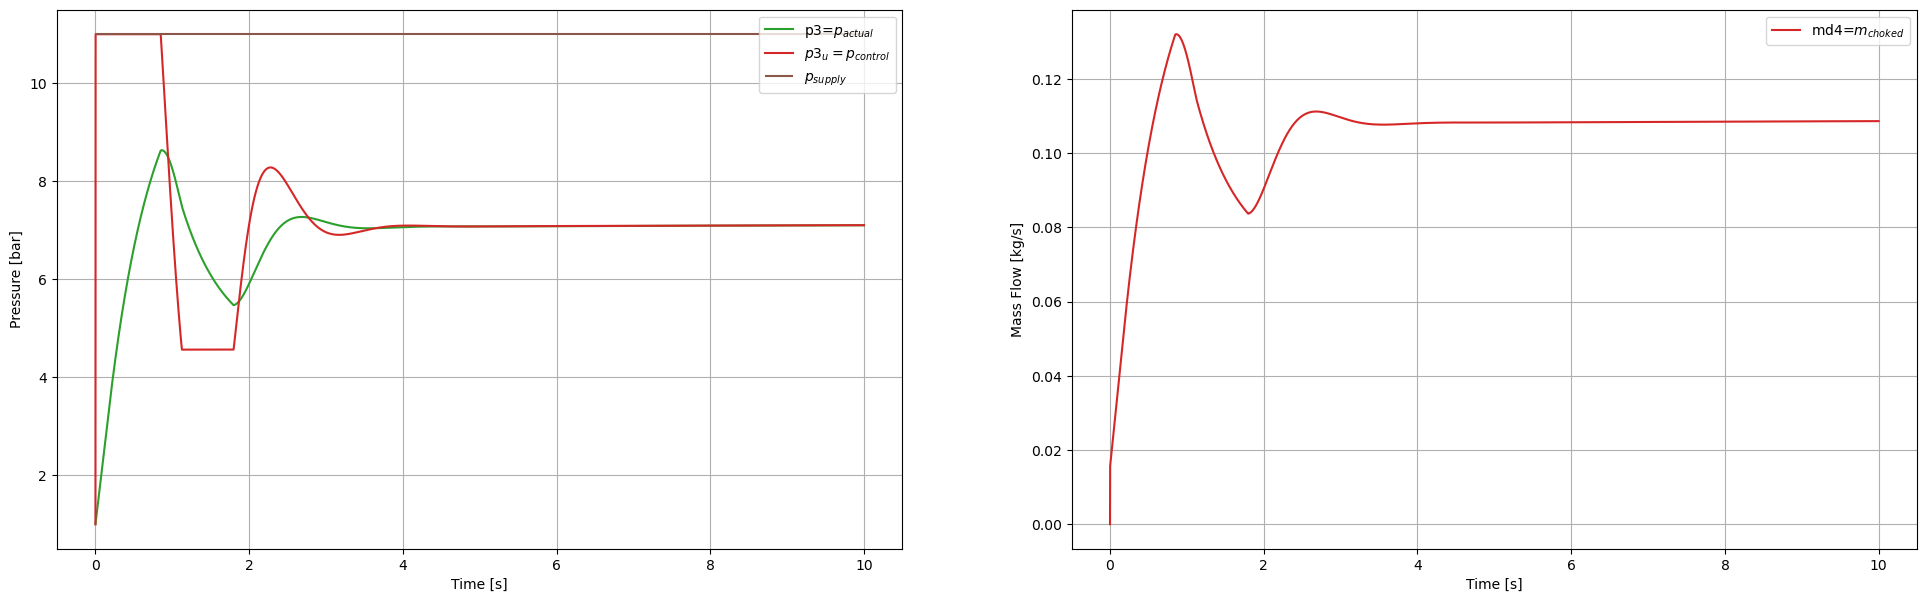

In [20]:
# Visualization

# part 1: pressure and mass flow rate

# Visualization

# part 1: pressure and mass flow rate
fig_p=plt.figure(figsize=(24,7))
plt.subplot(121)
plt.plot(time[:-1], state_t[0, :-1]/1e5, label='p3=$p_{actual}$', color='C2')
plt.plot(time[:-1], state_t[1, :-1]/1e5, label='$p3_u=p_{control}$', color='C3')
plt.hlines(p_s/1e5,xmin=0,xmax=tf,label='$p_{supply}$', color='C5')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time[:-1], state_t[2, :-1], label='md4=$m_{choked}$', color='C3')
plt.xlabel('Time [s]')
plt.ylabel('Mass Flow [kg/s]')
plt.grid()
plt.legend()

plt.show()

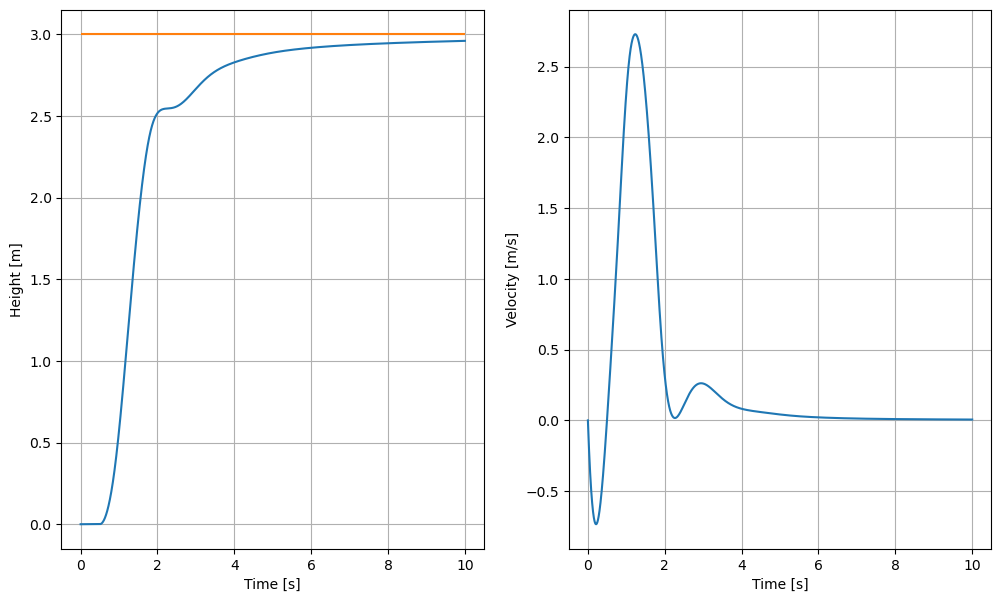

In [21]:
# part 3: motion changed (lower target height will increase the time to converge, so you need to set tf larger)
fig_m=plt.figure(figsize=(12,7))
plt.subplot(121)
plt.plot(time[:-1], motion_t[0, :-1], label='x',color="C0")
plt.hlines(x_target,xmin=0,xmax=tf,label="target",colors="C1")
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()


plt.subplot(122)
plt.plot(time[:-1], motion_t[1, :-1], label='v')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid()

plt.show()